In [ ]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown


In [ ]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import gdown

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset as TorchDataset, DataLoader
from torchvision import models, transforms

EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True

TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')

DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}


In [ ]:
class Dataset:
    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        file_name = f"{name}.npz"
        if not os.path.exists(file_name):
            raise FileNotFoundError("нет файла " + file_name)
        print("загружаю датасет", name, "из", file_name)
        np_obj = np.load(file_name)
        self.images = np_obj["data"]
        self.labels = np_obj["labels"]
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print("готово, картинок:", self.n_files)

    def image(self, i):
        if not self.is_loaded:
            raise RuntimeError("датасет не загружен")
        return self.images[i, :, :, :]

    def images_seq(self, n=None):
        total = self.n_files if n is None else n
        for i in range(total):
            yield self.image(i)

    def random_image_with_label(self):
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        idx = np.random.choice(self.n_files, n)
        imgs = [self.image(i) for i in idx]
        labels = np.array([self.labels[i] for i in idx])
        return np.stack(imgs), labels

    def image_with_label(self, i):
        return self.image(i), self.labels[i]


In [ ]:
class Metrics:
    @staticmethod
    def accuracy(gt, pred):
        if len(gt) != len(pred):
            raise ValueError("gt and pred different length")
        s = 0
        for a, b in zip(gt, pred):
            if a == b:
                s += 1
        return s / len(gt)

    @staticmethod
    def accuracy_balanced(gt, pred):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt, pred, info):
        print("metrics", info)
        acc = Metrics.accuracy(gt, pred)
        bacc = Metrics.accuracy_balanced(gt, pred)
        print("acc", acc)
        print("balanced_acc", bacc)


In [ ]:
class HistologyTorchDataset(TorchDataset):
    def __init__(self, base_dataset, indices, transform=None):
        self.base = base_dataset
        self.indices = np.array(indices)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = int(self.indices[idx])
        img = self.base.images[real_idx]
        label = int(self.base.labels[real_idx])
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        return img, label


class Model:
    def __init__(self, num_classes=len(TISSUE_CLASSES), project_name="histology_cnn", save_dir=None):
        self.num_classes = num_classes
        self.project_name = project_name
        self.save_dir = save_dir or os.path.join(BASE_DIR, "histology_models")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("device:", self.device)

        #LBL11 аугментации изображений
        self.train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5]),
        ])

        self.eval_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5]),
        ])

        self.model = models.resnet18(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)
        self.model = self.model.to(self.device)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4, weight_decay=1e-4)
        self.history = {"train_loss": [], "val_loss": [], "val_acc": []}

    #LBL1 валидация на части обучающей выборки
    def _make_dataloaders(self, dataset, batch_size=64, val_split=0.2, seed=42):
        np.random.seed(seed)
        idx = np.arange(dataset.n_files)
        np.random.shuffle(idx)
        split = int(len(idx) * (1.0 - val_split))
        train_idx = idx[:split]
        val_idx = idx[split:]
        train_ds = HistologyTorchDataset(dataset, train_idx, transform=self.train_transform)
        val_ds = HistologyTorchDataset(dataset, val_idx, transform=self.eval_transform)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
        print("train samples:", len(train_ds), "val samples:", len(val_ds))
        return train_loader, val_loader

    #LBL3 сохранение модели по эпохам
    def save(self, name):
        os.makedirs(self.save_dir, exist_ok=True)
        path = os.path.join(self.save_dir, f"{name}.pt")
        torch.save({"model_state_dict": self.model.state_dict(), "num_classes": self.num_classes}, path)
        print("saved model to", path)

    #LBL4 загрузка модели по имени чекпоинта
    def load(self, name):
        os.makedirs(self.save_dir, exist_ok=True)
        path = os.path.join(self.save_dir, f"{name}.pt")
        if not os.path.exists(path):
            file_id = "PUT_YOUR_FILE_ID_HERE"
            if file_id is None or file_id == "" or "PUT_YOUR_FILE_ID_HERE" in file_id:
                raise FileNotFoundError("нет файла с весами " + path + " и не задан file_id")
            url = "https://drive.google.com/uc?id=" + file_id
            print("скачиваю веса из", url)
            gdown.download(url, path, quiet=False)
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.model.to(self.device)
        self.model.eval()
        print("loaded model from", path)

    def train(self, dataset, epochs=10, batch_size=64, lr=1e-4, val_split=0.2):
        for g in self.optimizer.param_groups:
            g["lr"] = lr

        train_loader, val_loader = self._make_dataloaders(dataset, batch_size=batch_size, val_split=val_split)
        best_val_acc = 0.0

        for epoch in range(1, epochs + 1):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for images, labels in train_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * labels.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            train_loss = running_loss / total
            train_acc = correct / total

            self.model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            all_val_preds = []
            all_val_labels = []

            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(self.device)
                    labels = labels.to(self.device)

                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)

                    val_loss += loss.item() * labels.size(0)
                    _, preds = torch.max(outputs, 1)
                    val_correct += (preds == labels).sum().item()
                    val_total += labels.size(0)

                    all_val_preds.append(preds.cpu().numpy())
                    all_val_labels.append(labels.cpu().numpy())

            val_loss = val_loss / val_total
            val_acc = val_correct / val_total
            all_val_preds = np.concatenate(all_val_preds)
            all_val_labels = np.concatenate(all_val_labels)

            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)

            #LBL5 вывод метрик обучения по эпохам
            print("epoch", epoch, "/", epochs)
            print("train_loss", float(train_loss), "train_acc", float(train_acc))
            print("val_loss", float(val_loss), "val_acc", float(val_acc))
            Metrics.print_all(all_val_labels, all_val_preds, "val epoch " + str(epoch))

            ckpt_name = f"{self.project_name}_epoch_{epoch}"
            self.save(ckpt_name)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                self.save("best")
                print("new best model, val_acc", best_val_acc)

    def test_on_dataset(self, dataset, limit=None):
        predictions = []
        n = dataset.n_files if limit is None else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img):
        self.model.eval()
        with torch.no_grad():
            pil_img = Image.fromarray(img)
            tensor = self.eval_transform(pil_img).unsqueeze(0).to(self.device)
            outputs = self.model(tensor)
            _, pred = torch.max(outputs, 1)
            return int(pred.item())

    #LBL8 матрица ошибок и визуализация результатов теста
    #LBL10 сохранение предсказаний и матрицы ошибок в npz
    def evaluate_and_visualize(self, dataset, dataset_name="test", save_prefix=None):
        y_pred = self.test_on_dataset(dataset)
        y_true = dataset.labels[:len(y_pred)]
        Metrics.print_all(y_true, y_pred, dataset_name)
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=TISSUE_CLASSES)
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6, 6))
        disp.plot(include_values=True, cmap="Blues", xticks_rotation=45, colorbar=False)
        plt.title("confusion " + dataset_name)
        plt.tight_layout()
        plt.show()
        if save_prefix is not None:
            os.makedirs(self.save_dir, exist_ok=True)
            out_path = os.path.join(self.save_dir, save_prefix + "_results.npz")
            np.savez(out_path, y_true=y_true, y_pred=y_pred, cm=cm)
            print("saved test results to", out_path)

    #LBL6 построение графиков потерь и точности
    def plot_history(self):
        if not self.history["train_loss"]:
            print("нет истории, сперва train()")
            return

        import matplotlib.pyplot as plt
        epochs = range(1, len(self.history["train_loss"]) + 1)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history["train_loss"], label="train_loss")
        plt.plot(epochs, self.history["val_loss"], label="val_loss")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.title("Loss")
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.history["val_acc"], label="val_acc")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.legend()
        plt.title("Validation accuracy")
        plt.show()


In [ ]:
!cp '/content/drive/MyDrive/train_small.npz' 'train_small.npz'
!cp '/content/drive/MyDrive/test_small.npz' 'test_small.npz'
!cp '/content/drive/MyDrive/train_tiny.npz' 'train_tiny.npz'
!cp '/content/drive/MyDrive/test_tiny.npz' 'test_tiny.npz'


In [ ]:
d_train = Dataset('train_small')
d_test = Dataset('test_small')

model = Model()

if not EVALUATE_ONLY:
    model.train(d_train, epochs=10, batch_size=64, lr=1e-4, val_split=0.2)
    model.save('best')
else:
    model.load('best')


загружаю датасет train_small из train_small.npz
готово, картинок: 7200
загружаю датасет test_small из test_small.npz
готово, картинок: 1800
device: cuda
train samples: 5760 val samples: 1440


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch 1 / 10
train_loss 0.3891139162911309 train_acc 0.8835069444444444
val_loss 0.12248263541195127 val_acc 0.9583333333333334
metrics val epoch 1
acc 0.9583333333333334
balanced_acc 0.9586159705542363
saved model to /content/drive/MyDrive/histology_models/histology_cnn_epoch_1.pt
saved model to /content/drive/MyDrive/histology_models/best.pt
new best model, val_acc 0.9583333333333334
epoch 2 / 10
train_loss 0.12813870646059514 train_acc 0.9611111111111111
val_loss 0.09408153659767575 val_acc 0.9694444444444444
metrics val epoch 2
acc 0.9694444444444444
balanced_acc 0.969383946323731
saved model to /content/drive/MyDrive/histology_models/histology_cnn_epoch_2.pt
saved model to /content/drive/MyDrive/histology_models/best.pt
new best model, val_acc 0.9694444444444444
epoch 3 / 10
train_loss 0.08865169868287114 train_acc 0.971875
val_loss 0.09156510043475363 val_acc 0.9701388888888889
metrics val epoch 3
acc 0.9701388888888889
balanced_acc 0.9706242895233825
saved model to /content/driv

In [ ]:
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')


  0%|          | 0/180 [00:00<?, ?it/s]

metrics 10% of test
acc 0.9944444444444445
balanced_acc 0.9944444444444445


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  0%|          | 0/1800 [00:00<?, ?it/s]

metrics test
acc 0.9816666666666667
balanced_acc 0.9816666666666668


device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded model from /content/drive/MyDrive/histology_models/best.pt
загружаю датасет test_small из test_small.npz
готово, картинок: 1800


  0%|          | 0/1800 [00:00<?, ?it/s]

metrics test-small
acc 0.9816666666666667
balanced_acc 0.9816666666666668


<Figure size 600x600 with 0 Axes>

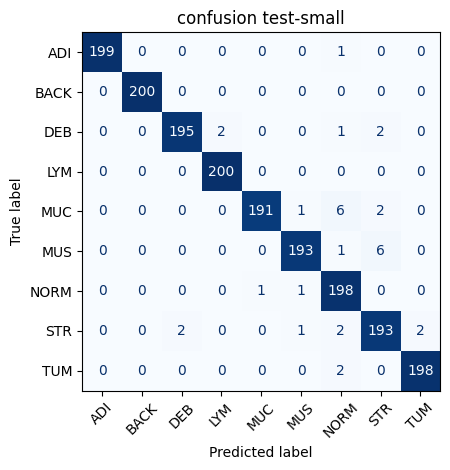

saved test results to /content/drive/MyDrive/histology_models/test_small_results.npz


In [ ]:
final_model = Model()
final_model.load('best')

d_test_tiny = Dataset('test_small')
final_model.evaluate_and_visualize(d_test_tiny, dataset_name='test-small', save_prefix='test_small')


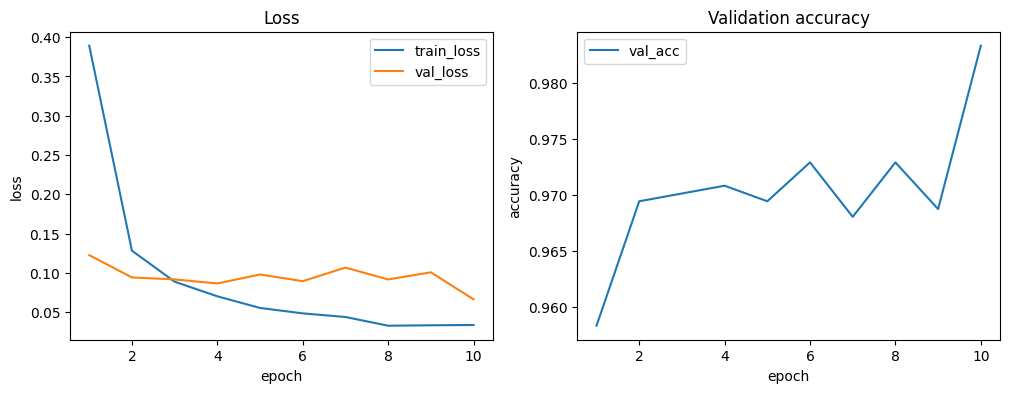

In [ ]:
model.plot_history()
